Llamamos la paquetería necesaria

In [2]:
using TaylorIntegration, ValidatedNumerics, TaylorSeries
using Plots, LaTeXStrings
# plotly()
pyplot(grid = :false, legend = :false)
const λ = 1.0
const Z = 2.0
const order = 40
const t0 = 0.0
const t_max = 0.5 
const abs_tol = 1.0E-20
const steps = 500000

500000

In [3]:
function undrivenHelium(τ, q)
    t, Q₁, P₁, Q₂, P₂ = q
    
    t = Q₁^2*Q₂^2
    q₁ = 0.25*Q₂^2*P₁
    p₁ = 2Q₁*(-0.125P₂^2 + Z  - Q₂^2 - Q₂^2/abs(Q₁^2 - Q₂^2)) + 2*Q₁^3*Q₂^2*((Q₁^2 - Q₂^2)/abs(Q₁^2 - Q₂^2)^3)
    q₂ = 0.25*Q₁^2*P₂
    p₂ = 2Q₂*(-0.125P₁^2 + Z  - Q₁^2 - Q₁^2/abs(Q₁^2 - Q₂^2)) - 2*Q₁^2*Q₂^3*((Q₁^2 - Q₂^2)/abs(Q₁^2 - Q₂^2)^3)

    return [t, q₁, p₁, q₂, p₂] 

end
undrivenHelium(v) = undrivenHelium(0, v)

var1 = set_variables("t q1 p1 q2 p2", order = 1)


function condini(x10::Float64, px10::Float64)
    @assert x10 != 0
    Q1 = sqrt(x10)
    Q2 = 0.0
    P1 = px10*sqrt(x10)    
    P2 = sqrt(8Z)    
    return [0, Q1, P1, Q2, P2]
end

function regHam(t, Q₁, P₁, Q₂, P₂)
    #Cantidades auxiliares
    P₁² = P₁^2
    P₂² = P₂^2
    Q₁² = Q₁^2
    Q₂² = Q₂^2
    nf = sqrt(((Q₁)^2 - (Q₂)^2)^2)
    
    H = 0.125*(P₁²*Q₂² + P₂²*Q₁²) - Z*(Q₁² + Q₂²) + Q₁²*Q₂²*(1.0 + 1.0/nf)
    return H
end


regHam(v) = regHam(v...)


function errHam(N::Int)
    dQ1 = zeros(N)
    dQ2 = zeros(N)
    dP1 = zeros(N)
    dP2 = zeros(N)
    als = typeof(zeros(5))[]
    for j in 1:N
        al = 10*rand(5)
        alt = al + var1
        ene = regHam(alt)
        meq = undrivenHelium(al)
        
        dQ1[j] = abs(meq[2] - ene.coeffs[2].coeffs[3])
        dQ2[j] = abs(meq[4] - ene.coeffs[2].coeffs[5])
        dP1[j] = abs(meq[3] + ene.coeffs[2].coeffs[2])
        dP2[j] = abs(meq[5] + ene.coeffs[2].coeffs[4])
        push!(als, al)
    end
    return dQ1, dQ2, dP1, dP2, als        
end

errHam (generic function with 1 method)

In [4]:
#Haremos malavares con metaprogramming para ver varias órbitas
nombret(n::Int) = Symbol( string("t", n) )
nombreq(n::Int) = Symbol( string("q", n) )

function orbits(rs = 2:10)
    N = length(rs)
    # Checo que `n` sea >= 1
    @assert N >= 0  

    for j = 1:N
        ex = quote 
                $(nombret(j)), $(nombreq(j)) = 
                taylorinteg(undrivenHelium, condini(Float64($(rs[j])), 0.0), t0, 
                15.0, order, abs_tol, maxsteps=steps) 
             end
        eval(ex)  
    end
end

orbits (generic function with 2 methods)

In [28]:
v = condini(3.2,1.)

5-element Array{Float64,1}:
 0.0    
 1.78885
 1.78885
 0.0    
 4.0    

In [29]:
undrivenHelium(v)

5-element Array{Float64,1}:
  0.0
  0.0
  0.0
  3.2
 -0.0

In [22]:
undrivenHelium(ans)

5-element Array{Float64,1}:
 NaN
 NaN
 NaN
 NaN
 NaN


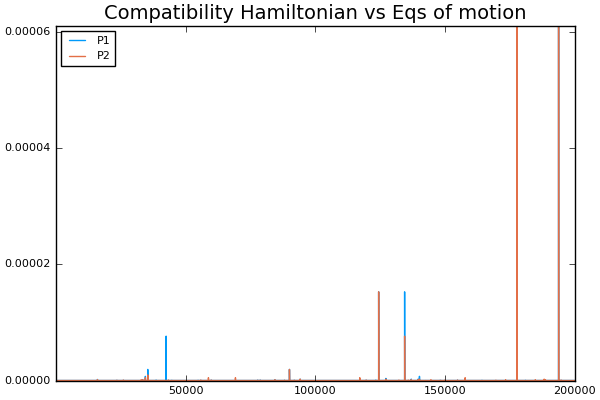

In [27]:
dQ1, dQ2, dP1, dP2, als = errHam(200_000);
plot(eachindex(dP1), dP1, label ="P1", title = "Compatibility Hamiltonian vs Eqs of motion")
plot!(eachindex(dP2), dP2, label = "P2",legend = :true)

In [6]:
maximum(dP2)

4.547473508864641e-13

The final state:

In [6]:
t1[end], q1[end,:]

(15.0,[12695.0,94.5704,133.043,0.942187,-2.67248])

In [7]:
regHam(q1[end,:])

2.2282620193436742e-10

In [35]:
ene = zeros(t1)
for j in eachindex(ene)
    ene[j] = abs(regHam(q1[j,:]))
end


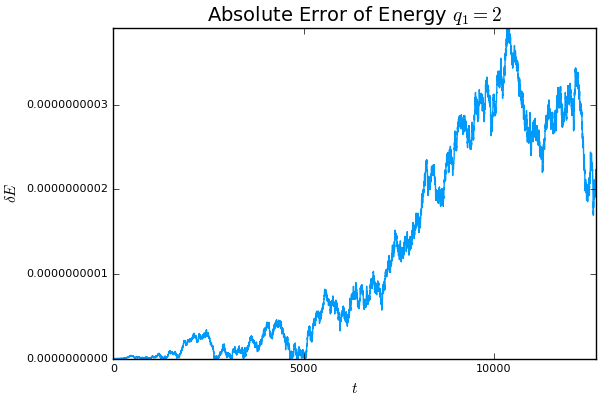

In [41]:
plot(q1[:,1], ene, title =L"Absolute Error of Energy $q_1=2$")
xlabel!(L"t")
ylabel!(L"\delta E")

In [10]:
function ksv(Q, P)
    v₁ = P/Q
    return v₁
end
ks(Q) = Q^2

ks (generic function with 1 method)

In [11]:
xs1 = map(ks, q1[:,2])
vxs1 = Float64[ksv(q1[j,2], q1[j,3]) for j in eachindex(t1)]
xs2 = map(ks, q2[:,2])
vxs2 = Float64[ksv(q2[j,2], q2[j,3]) for j in eachindex(t2)]
xs3 = map(ks, q3[:,2])
vxs3 = Float64[ksv(q3[j,2], q3[j,3]) for j in eachindex(t3)]
xs4 = map(ks, q4[:,2])
vxs4 = Float64[ksv(q4[j,2], q4[j,3]) for j in eachindex(t4)]
xs5 = map(ks, q5[:,2])
vxs5 = Float64[ksv(q5[j,2], q5[j,3]) for j in eachindex(t5)]
xs6= map(ks, q6[:,2])
vxs6 = Float64[ksv(q6[j,2], q6[j,3]) for j in eachindex(t6)]
xs7 = map(ks, q7[:,2])
vxs7 = Float64[ksv(q7[j,2], q7[j,3]) for j in eachindex(t7)]
xs8 = map(ks, q8[:,2])
vxs8 = Float64[ksv(q8[j,2], q8[j,3]) for j in eachindex(t8)]
xs9 = map(ks, q9[:,2])
vxs9 = Float64[ksv(q9[j,2], q9[j,3]) for j in eachindex(t9)];


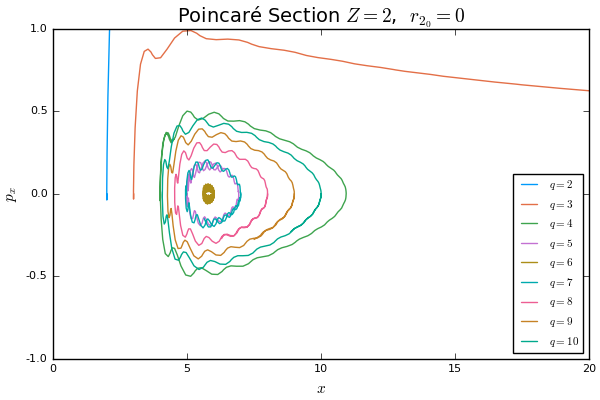

In [33]:
plot(xs1, vxs1,label = L"q = 2", title = L"Poincaré Section $Z = 2$,  $r_{2_0} =0$", legend =:true)
plot!(xs2, vxs2,label = L"q = 3")
plot!(xs3, vxs3,label = L"q = 4")
plot!(xs4, vxs4,label = L"q = 5")
plot!(xs5, vxs5,label = L"q = 6")
plot!(xs6, vxs6,label = L"q = 7")
plot!(xs7, vxs7,label = L"q = 8")
plot!(xs8, vxs8,label = L"q = 9")
plot!(xs9, vxs9,label = L"q = 10")
xaxis!([0,20])
xlabel!(L"x")
ylabel!(L"p_x")
yaxis!([-1,1])

In [23]:
function HamU(t, Q₁, P₁, Q₂, P₂)
    #Cantidades auxiliares
    P₁² = P₁^2
    P₂² = P₂^2
    Q₁² = Q₁^2
    Q₂² = Q₂^2
    nq = abs(Q₁ - Q₂)
    
    H = 0.5*(P₁² + P₂²) - Z*(1/abs(Q₁)+1/abs(Q₂)) + 1.0/nq
    return H
end
HamU(v) = HamU(v...)

HamU (generic function with 2 methods)

In [29]:
ene1 = zeros(t1)
for j in 2:length(t1)
    ene1[j] = abs(HamU(q1[j,:]) + 1)
end


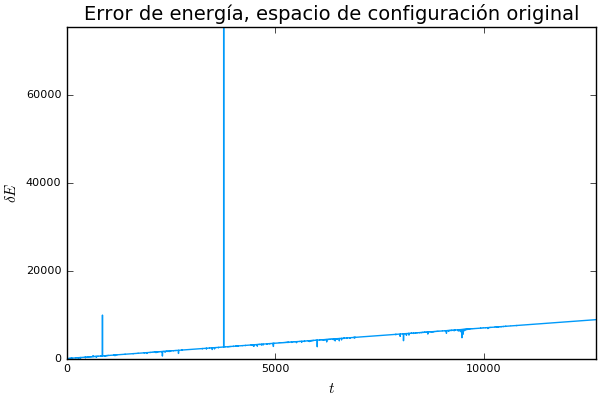

In [42]:
plot(q1[:,1], ene1, title ="Error de energía, espacio de configuración original")
xlabel!(L"t")
ylabel!(L"\delta E")